## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Code: Preprocessing


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# 2. Handle missing values (replace NaNs with column mean)
X = X.fillna(X.mean())

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Split Data into Train, Validation, and Test Sets


In [ ]:
# First split: train vs temp (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42, stratify=y)

# Second split: validation vs test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (2293, 9)
Validation set: (491, 9)
Test set: (492, 9)


## Build & Compile the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Define the model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.35),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.35),

    layers.Dense(1, activation='sigmoid')  # Binary output for classification
])

# Compile with Adam optimizer and custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


## Early Stopping and Training Code

In [ ]:
# Early stopping callback: monitor val_accuracy with patience = 10
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5517 - auc: 0.5324 - loss: 0.9697 - precision: 0.4116 - recall: 0.3702 - val_accuracy: 0.6090 - val_auc: 0.5663 - val_loss: 0.8552 - val_precision: 0.3333 - val_recall: 0.0052
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6178 - auc: 0.5787 - loss: 0.8346 - precision: 0.5423 - recall: 0.1514 - val_accuracy: 0.6314 - val_auc: 0.6298 - val_loss: 0.7820 - val_precision: 0.7778 - val_recall: 0.0733
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6373 - auc: 0.6116 - loss: 0.7716 - precision: 0.6034 - recall: 0.2076 - val_accuracy: 0.6578 - val_auc: 0.6450 - val_loss: 0.7374 - val_precision: 0.7447 - val_recall: 0.1832
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6544 - auc: 0.6376 - loss: 0.7244 - precision: 0.6558 - recall: 0.2088 - val_accuracy: 0.6558 - val_auc: 0.6454 - val_loss: 0.7104 - val_precision: 0.7115 - val_recall: 0.1937
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━

## Plot Accuracy and Loss Curves

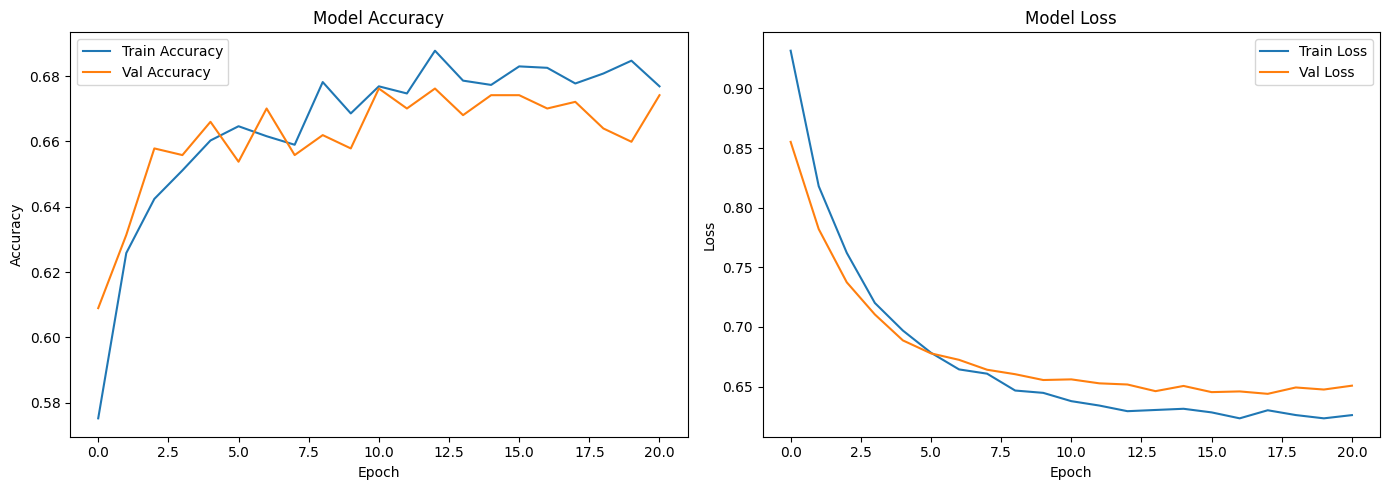

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##  Evaluate the Model on the Test Set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

# Predict probabilities and class labels
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))

# F1, Precision, Recall, AUC
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.94      0.79       300
           1       0.78      0.34      0.48       192

    accuracy                           0.71       492
   macro avg       0.73      0.64      0.64       492
weighted avg       0.72      0.71      0.67       492

F1 Score: 0.4765
Precision: 0.7765
Recall: 0.3438
AUC: 0.6904
